In [732]:
import pandas as pd
import numpy as np

In [734]:
# Importing main data cell lines and drug response
cell_lines_pd = pd.read_csv ("OmicsExpressionProteinCodingGenesTPMLogp1.csv", index_col=0)
response_pd = pd.read_csv ("Repurposing_Public_24Q2_Extended_Primary_Data_Matrix.csv", index_col=0)

In [735]:
print(cell_lines_pd.shape)

(1673, 19193)


In [736]:
print(response_pd.shape)
print(response_pd.isnull().sum().sum())

(6790, 919)
2026962


In [737]:
#Transposing response drugs to rows to posteriously merge to lines dataset
response_transposed = response_pd.T

## Filtering both datasets to only have the common ones 

In [739]:
# Checking for common cell lines
common_cells = cell_lines_pd.index.intersection(response_transposed.index)

In [740]:
# Filtering both with common cell lines
genes_filtered    = cell_lines_pd.loc[common_cells]
response_filtered = response_transposed.loc[common_cells]

In [741]:
print(genes_filtered .shape)

(901, 19193)


In [742]:
print(response_filtered.shape)

(901, 6790)


## Data exploration (Drug efficacy Y)

In [746]:
# Checking for duplicate values 
print(genes_filtered.index.duplicated().sum())  

0


In [749]:
print(response_filtered.index.duplicated().sum())  

0


In [750]:
# Checking for empty values
print(genes_filtered.isnull().sum().sum())
print(response_filtered.isnull().sum().sum())

0
1967792


In [755]:
# Checking coverage of each drud , finding the most stable and less NaN values
coverage = response_filtered.notna().sum().sort_values(ascending=False)
print(coverage.head())

BRD:BRD-K05804044-001-18-5    884
BRD:BRD-K92723993-001-17-4    882
BRD:BRD-A00047421-001-01-7    878
BRD:BRD-K00003257-001-01-9    878
BRD:BRD-K00003262-001-01-9    878
dtype: int64


In [757]:
# Variability check per drug
variability = response_filtered.var(skipna=True).sort_values(ascending=False)
print(variability.head())

BRD:BRD-K00003313-001-01-9    13.196467
BRD:BRD-K00003295-300-01-9    12.776134
BRD:BRD-K00003273-003-01-9    11.840242
BRD:BRD-K00003515-003-01-9    11.027894
BRD:BRD-K00004604-001-01-9    10.859447
dtype: float64


In [758]:
# Combining both for best drug 
drug_summary = pd.DataFrame({
    'coverage': response_filtered.notna().sum(),
    'variance': response_filtered.var(skipna=True)
})
drug_summary['score'] = drug_summary['coverage'] * drug_summary['variance']
drug_summary_sorted = drug_summary.sort_values(by='score', ascending=False)

print(drug_summary_sorted.head())

                            coverage   variance         score
BRD:BRD-K00003313-001-01-9       878  13.196467  11586.498272
BRD:BRD-K00003295-300-01-9       878  12.776134  11217.445550
BRD:BRD-K00003273-003-01-9       878  11.840242  10395.732682
BRD:BRD-K00003515-003-01-9       878  11.027894   9682.490858
BRD:BRD-K00004604-001-01-9       873  10.859447   9480.297166


In [761]:
# Setting target drug for the model from top 5
target_drug = "BRD:BRD-K00003313-001-01-9"

In [762]:
# subseting for target drug 
drug_df = response_filtered[[target_drug]].dropna().copy()

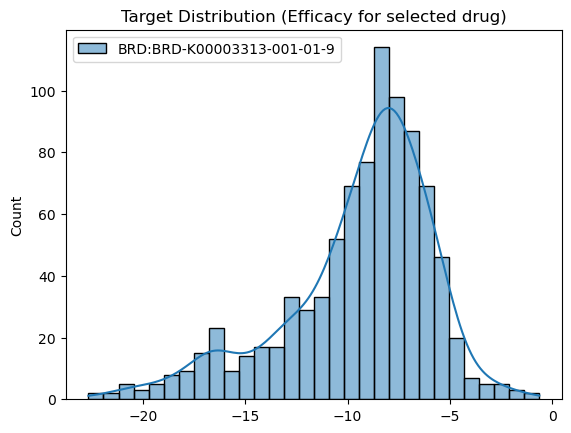

In [763]:
# Drug distribution checking for skewness
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(drug_df, bins=30, kde=True)
plt.title("Target Distribution (Efficacy for selected drug)")
plt.show()

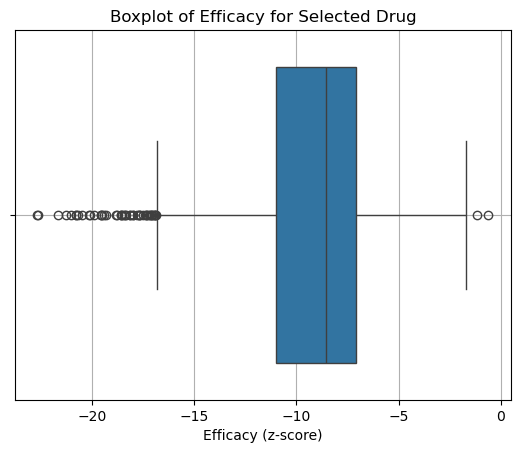

In [765]:
# Outlayers 

sns.boxplot(x=drug_df.squeeze())
plt.title("Boxplot of Efficacy for Selected Drug")
plt.xlabel("Efficacy (z-score)")
plt.grid(True)
plt.show()

In [766]:
# Cap outliers in drug_df using IQR method (Winsorization)
Q1 = drug_df[target_drug].quantile(0.25)
Q3 = drug_df[target_drug].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

drug_df[target_drug] = drug_df[target_drug].clip(lower=lower_bound, upper=upper_bound)

drug_df.info()
drug_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 878 entries, ACH-001113 to ACH-000052
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BRD:BRD-K00003313-001-01-9  878 non-null    float64
dtypes: float64(1)
memory usage: 46.0+ KB


,BRD:BRD-K00003313-001-01-9
ACH-001113,-8.461378
ACH-001289,-9.195708
ACH-001538,-9.585021
ACH-000242,-7.567494
ACH-000233,-10.629807


## Data exploration (Genes X)

In [770]:
# Checking for common cell lines
common_cells = genes_filtered.index.intersection(drug_df.index)

# Filtering both with common cell lines
genes_filtered2    = genes_filtered.loc[common_cells]
response_filtered2 = drug_df.loc[common_cells]

In [774]:
# Correlation values for genes
assert all(genes_filtered2.index == response_filtered2.index)

y = response_filtered2[target_drug]

# Computing correlations for each gene
gene_correlations = genes_filtered.corrwith(y)

# Sort by absolute correlation
top_gene_corrs = gene_correlations.sort_values(key=lambda x: x.abs(), ascending=False)

# Display top 10
print(top_gene_corrs.head(10))

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TTC19 (54902)       0.132514
CLUAP1 (23059)      0.132064
MACROD1 (28992)     0.128665
LRRC75A (388341)    0.127590
ZFYVE28 (57732)     0.127491
FAM166C (339778)    0.125894
PARP4 (143)         0.124929
EVL (51466)        -0.123867
MOG (4340)         -0.122592
ACADVL (37)         0.122101
dtype: float64


In [654]:
# getting top genes 
top_ten_genes = top_gene_corrs.head(50).index

In [655]:
# Subseting top correlated genes 
top_cor_genes = genes_filtered[top_ten_genes]

# Merging both Datasets Gene expression and Drug efficacy 

In [661]:
print(top_cor_genes.reset_index().columns)
print(drug_df.reset_index().columns)

Index(['index', 'TTC19 (54902)', 'CLUAP1 (23059)', 'MACROD1 (28992)',
       'LRRC75A (388341)', 'ZFYVE28 (57732)', 'FAM166C (339778)',
       'PARP4 (143)', 'EVL (51466)', 'MOG (4340)', 'ACADVL (37)',
       'EGLN2 (112398)', 'DNASE1L3 (1776)', 'PSORS1C1 (170679)',
       'BASP1 (10409)', 'ZNF331 (55422)', 'CCNH (902)', 'METTL15 (196074)',
       'STPG4 (285051)', 'ACBD4 (79777)', 'RNF32 (140545)', 'C11orf54 (28970)',
       'MFSD6 (54842)', 'ZNF568 (374900)', 'LYRM1 (57149)',
       'C11orf45 (219833)', 'PIH1D2 (120379)', 'XRCC4 (7518)',
       'ABHD10 (55347)', 'CFAP69 (79846)', 'RASA1 (5921)', 'WDR93 (56964)',
       'SLC24A1 (9187)', 'GRM1 (2911)', 'SPATS2L (26010)', 'HSD3B7 (80270)',
       'ENTPD7 (57089)', 'IQCK (124152)', 'NAAA (27163)', 'ZNF688 (146542)',
       'PALMD (54873)', 'AUH (549)', 'NID2 (22795)', 'ELOVL4 (6785)',
       'FAM187A (100528020)', 'STAP2 (55620)', 'FBLN2 (2199)', 'NFKBIB (4793)',
       'RPH3AL (9501)', 'ERVFRD-1 (405754)', 'TAF12 (6883)'],
      dtype=

In [662]:
# Pre-process data to merge
drug_to_merge = drug_df.reset_index().rename(columns={'index': 'cell_line'})
genes_to_merge = top_cor_genes.reset_index().rename(columns={'index': 'cell_line'})

In [663]:
# Merging both datasets by cell line
model_df = pd.merge(drug_to_merge, genes_to_merge, on='cell_line')

In [669]:
print("\nSuccessfully created the final modeling DataFrame:")
print(model_df.head())
print(f"Shape of the final DataFrame: {model_df.shape}")


Successfully created the final modeling DataFrame:
    cell_line  BRD:BRD-K00003313-001-01-9  TTC19 (54902)  CLUAP1 (23059)  \
0  ACH-001113                   -8.461378       4.395063        4.272770   
1  ACH-001289                   -9.195708       5.175924        4.476382   
2  ACH-001538                   -9.585021       4.400538        4.961160   
3  ACH-000242                   -7.567494       4.706531        2.211012   
4  ACH-000233                  -10.629807       4.110196        4.021480   

   MACROD1 (28992)  LRRC75A (388341)  ZFYVE28 (57732)  FAM166C (339778)  \
0         1.521051          0.536053         2.289834          0.000000   
1         4.842979          2.056584         1.014355          0.000000   
2         3.868884          0.214125         0.807355          1.427606   
3         2.459432          0.516015         0.333424          0.014355   
4         5.010332          0.454176         5.354029          0.000000   

   PARP4 (143)  EVL (51466)  ...  AUH (5

# Spliting and scalling data 

In [779]:
from sklearn.preprocessing import StandardScaler
# Spliting X and y , features and target 
X = model_df.drop(columns=['cell_line', target_drug])
# Scalling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Target, drug efficacy for this drug
y = model_df[target_drug]

In [781]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 1_Regression Model 

In [681]:
# Baseline linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [682]:
y_pred = lr.predict(X_test)

In [683]:
# Evaluation 
# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Linear Regression R²: {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")

Linear Regression R²: 0.0864
Linear Regression RMSE: 3.2545


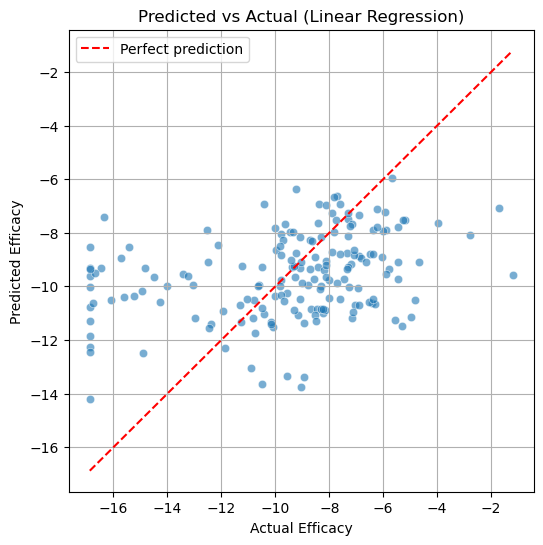

In [696]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect prediction')
plt.xlabel("Actual Efficacy")
plt.ylabel("Predicted Efficacy")
plt.title("Predicted vs Actual (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()

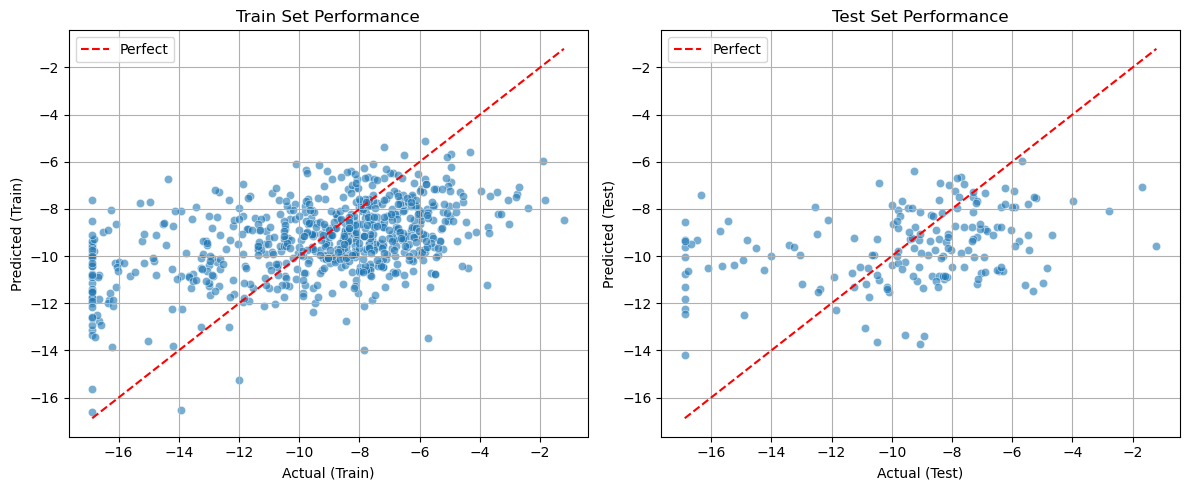

In [697]:
y_train_pred = lr.predict(X_train)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r', label='Perfect')
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted (Train)")
plt.title("Train Set Performance")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect')
plt.xlabel("Actual (Test)")
plt.ylabel("Predicted (Test)")
plt.title("Test Set Performance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

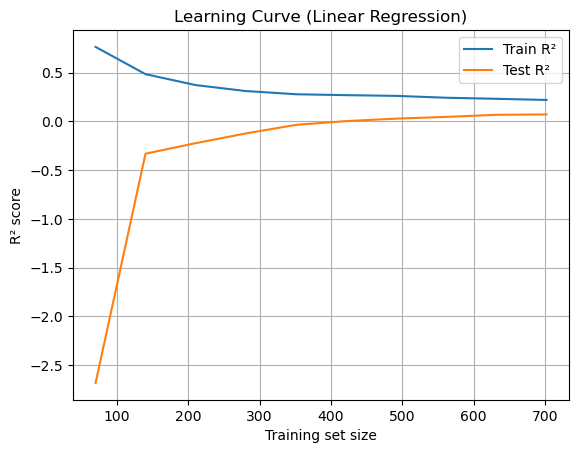

In [698]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Train R²")
plt.plot(train_sizes, test_scores_mean, label="Test R²")
plt.xlabel("Training set size")
plt.ylabel("R² score")
plt.title("Learning Curve (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()

# 2_Ridge CV 

In [700]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-3,5,9), cv=5)
ridge.fit(X_train , y_train)
y_pred = ridge.predict(X_test)

In [701]:
from sklearn.metrics import r2_score, mean_squared_error

print("Ridge R²:", r2_score(y_test, y_pred))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))  
print("Best alpha:", ridge.alpha_)

Ridge R²: 0.11745367713440957
Ridge RMSE: 3.198704619493164
Best alpha: 1000.0


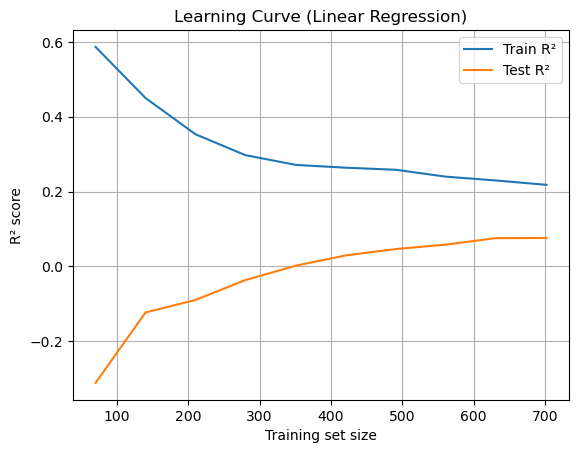

In [702]:
train_sizes, train_scores, test_scores = learning_curve(
    RidgeCV(), X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Train R²")
plt.plot(train_sizes, test_scores_mean, label="Test R²")
plt.xlabel("Training set size")
plt.ylabel("R² score")
plt.title("Learning Curve (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()

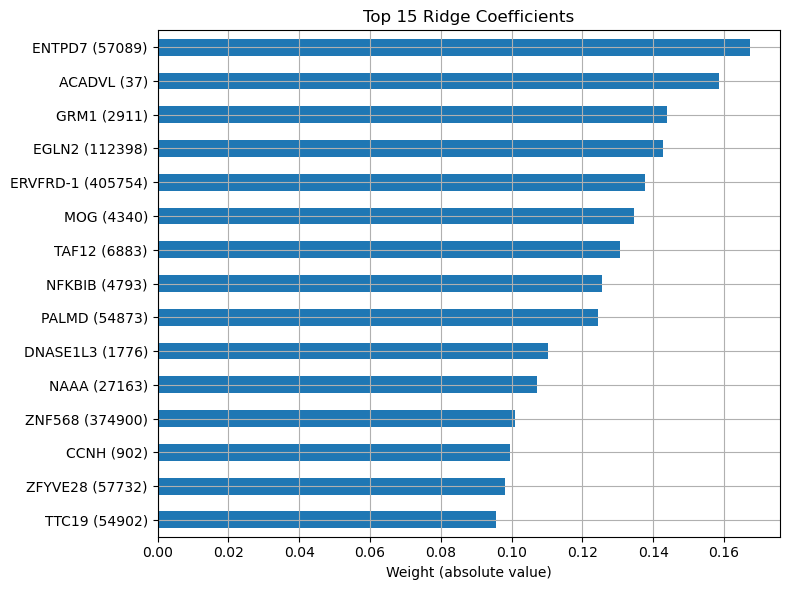

In [703]:
# Gene importand weights
import matplotlib.pyplot as plt

# Assuming you have gene names in X.columns
gene_weights = pd.Series(ridge.coef_, index=X.columns)
top_genes = gene_weights.abs().sort_values(ascending=False).head(15)

# Plot
top_genes.plot(kind='barh', figsize=(8, 6), title="Top 15 Ridge Coefficients")
plt.xlabel("Weight (absolute value)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3_XGBoost Regressor Model 

In [839]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# No scaled data for XGBoost
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train model
xgb = XGBRegressor(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.5,
    subsample=0.7,           # randomly use 70% of rows per tree
    colsample_bytree=0.3,    # randomly use 30% of features per tree
    reg_lambda=1.0,          # L2 regularization
    reg_alpha=0.5,           # L1 regularization
    random_state=42
)

In [841]:
# Train
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

In [843]:
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R²: {r2_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

XGBoost R²: -0.3906
XGBoost RMSE: 4.0151


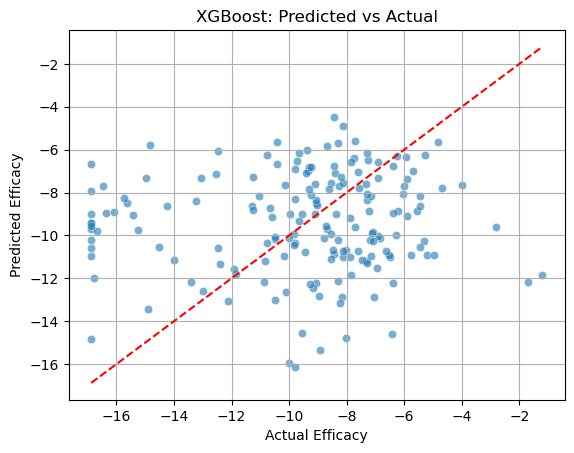

In [845]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Efficacy")
plt.ylabel("Predicted Efficacy")
plt.title("XGBoost: Predicted vs Actual")
plt.grid(True)
plt.show()

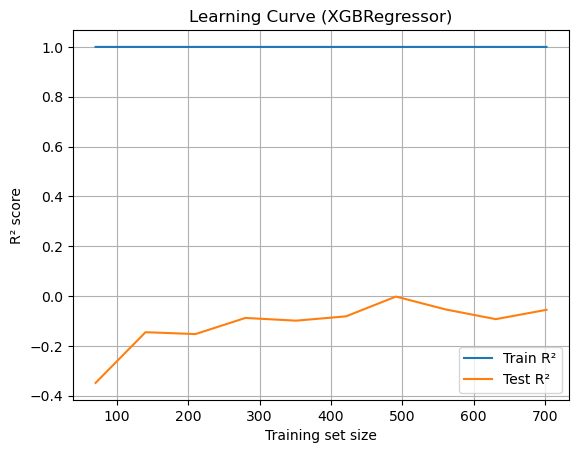

In [847]:
train_sizes, train_scores, test_scores = learning_curve(
     XGBRegressor(), X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Train R²")
plt.plot(train_sizes, test_scores_mean, label="Test R²")
plt.xlabel("Training set size")
plt.ylabel("R² score")
plt.title("Learning Curve (XGBRegressor)")
plt.legend()
plt.grid(True)
plt.show()